<a href="https://colab.research.google.com/github/Paulo-vitorCS/DeepLearning/blob/main/Projeto_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto 11: Classificação de Dígitos escritos à mão
###Rede Neural Convolucional MNIST


###Etapa 01: Importação das Bibliotecas

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets  # Acessar os datasets instalados no pytorch
import torchvision.transforms as transforms  # Transformações e carregamento das imagens

###Etapa 02: Base de Dados

In [2]:
torch.manual_seed(123)

In [3]:
transform = transforms.ToTensor()  # Download da base preparada para o pytorch

In [4]:
# root='.' salva na raiz do diretório do colab
# train = true cria a base de dados para treinamento
# transform = transform aplica o transformador criado acima para obter os dados no formato de tensor
train = datasets.MNIST(root = '.', train = True, download=True, transform=transform)
test = datasets.MNIST(root = '.', train = False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
train.data[0]  # Representação da primeira imagem

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
train.data.shape  # 60000 imagens com tamanho 28x28p

torch.Size([60000, 28, 28])

In [7]:
train.targets  # Respostas efetivas

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

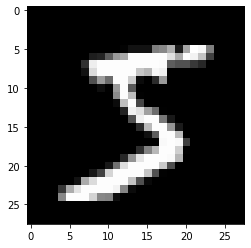

In [9]:
img = next(iter(train_loader))[0][0].view(28,28)  # Visualização de uma imagem
plt.imshow(img, cmap='gray')

In [10]:
img.shape

torch.Size([28, 28])

(array([639.,  11.,   6.,  11.,   6.,   9.,  11.,  12.,  11.,  68.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

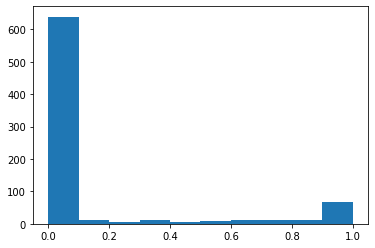

In [11]:
plt.hist(img.view(-1))  # Histograma

###Etapa 03: Construção do Modelo

In [14]:
class classificador(nn.Module):
    def __init__(self):
        super().__init__()

        # Parte convolucional
        # in_channels -> formato dos dados de entrada (1 canal -> imagens em escala de cinza)
        # out_channels -> número de filtros
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (3,3))
        self.conv2 = nn.Conv2d(32, 32, (3, 3))
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features = 32)  # Normalização dos dados dentro das camadas ocultas
        self.pool = nn.MaxPool2d(kernel_size = (2,2)) # Camada de Pooling
        self.flatten = nn.Flatten()  # 

        # output = (input - filter + 1) / stride
        # primeira camada de convolução: (28 - 3 + 1) / 1 = 26x26p
        # primeira camada de pooling: 13x13p
        # segunda camada de convolução: (13 - 3 + 1) / 1 = 11x11p 
        # segunda camada de pooling: 5x5p (desconsidera as bordas)
        # 5 * 5 * 32
        # 800 -> 128
        self.linear1 = nn.Linear(in_features = 32*5*5, out_features = 128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.dropout = nn.Dropout( p = 0.2)

    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X 


In [16]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

###Etapa 04: Treinamento do Modelo

In [17]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [18]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [23]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0. 

    for i, data in enumerate(loader):
        inputs, labels = data 
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy

        # Imprimindo os dados referentes a este loop:
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1,
                                                                                               i + 1,
                                                                                               len(loader),
                                                                                               loss,
                                                                                               accuracy), end = '\r')
    
    # Imprimindo os dados referentes a esta época:
    print('\rÉpoca {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1,
                                                                              running_loss/len(loader),
                                                                              running_accuracy/len(loader)))
        

In [24]:
for epoch in range(5):
    print('Treinando...')
    training_loop(train_loader, epoch)
    net.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    net.train()

Treinando...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Época   1 FINALIZADA: perda 0.02188 - precisão 0.99298
Validando...
Época   1 FINALIZADA: perda 0.02061 - precisão 0.99298
Treinando...
Época   2 FINALIZADA: perda 0.02115 - precisão 0.99336
Validando...
Época   2 FINALIZADA: perda 0.01976 - precisão 0.99407
Treinando...
Época   3 FINALIZADA: perda 0.01872 - precisão 0.99388
Validando...
Época   3 FINALIZADA: perda 0.01544 - precisão 0.99456
Treinando...
Época   4 FINALIZADA: perda 0.01646 - precisão 0.99444
Validando...
Época   4 FINALIZADA: perda 0.01551 - precisão 0.99535
Treinando...
Época   5 FINALIZADA: perda 0.01512 - precisão 0.99511
Validando...
Época   5 FINALIZADA: perda 0.01475 - precisão 0.99515


###Etapa 05: Avaliação do Modelo

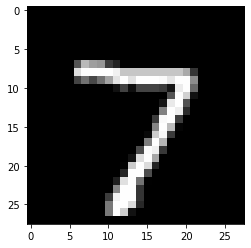

In [25]:
imagem = next(iter(test_loader))[0][0].view(28, 28)
plt.imshow(imagem, cmap='gray')

In [26]:
# (1, 1, 28, 28) -> (batch_size, númedo de canais, altura, largura)
imagem.shape

torch.Size([28, 28])

In [28]:
imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [29]:
net.eval()
imagem = imagem.to(device)

In [47]:
previsao = net.forward(imagem)
previsao

tensor([[ -5.1514,  -4.7931,  -2.7495,  -1.4630,  -5.1035,  -9.0813, -13.2846,
          12.0367,  -5.3631,  -0.8250]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [48]:
previsao = F.softmax(previsao)  # Formato de probabilidades
previsao

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[3.4300e-08, 4.9078e-08, 3.7881e-07, 1.3713e-06, 3.5982e-08, 6.7387e-10,
         1.0072e-11, 1.0000e+00, 2.7757e-08, 2.5954e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [49]:
previsao = previsao.cpu().detach().numpy()
previsao

array([[3.4300452e-08, 4.9077684e-08, 3.7881301e-07, 1.3713217e-06,
        3.5982097e-08, 6.7387151e-10, 1.0071565e-11, 9.9999547e-01,
        2.7756643e-08, 2.5954112e-06]], dtype=float32)

In [50]:
resultado = np.argmax(previsao) 

In [52]:
resultado  # Previsão da imagem acima

7